# Reading Numbers Using Keras and their training data
### Imports for keras and others:
### Read data for training and testing from keras dataset:
### Run very bottom block once to get images and colors

In [1]:
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
import os
import resource
def getMemUse():
    return " mem use: {:.5f}MB ".format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss*0.000001)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Dropout, Activation, Conv2D, MaxPooling2D

from matplotlib import pyplot as plt
from IPython.display import clear_output
import random

red_mask = (0.9,0.2,0.2)
green_mask = (0.2,0.9,0.2)
blue_mask = (0.2,0.2,0.9)
colors = {0:red_mask, 1:blue_mask, 2:green_mask}
colls = {0:"red", 1:"blue", 2:"green"}


### Normalize inputs from 0-255 to 0-1 as a float point:
### Change correct outputs to a 10 size categorical numpy array

In [19]:
# normalization by dividing by 255 seems to work well
# X_train = keras.utils.normalize(X_train, axis=1)
# X_test = keras.utils.normalize(X_test, axis=1)

# datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_it = datagen.flow_from_directory('images/train/', class_mode='categorical', target_size=(28,28), batch_size=64)
# test_it = datagen.flow_from_directory('images/test/', class_mode='categorical', target_size=(28,28), batch_size=64)

X_train = np.zeros([60000,28,28,3])
X_test = np.zeros([10000,28,28,3])

Y_train = np.zeros([60000,10])
Y_test = np.zeros([10000,10])

Y_train_color = np.zeros([60000,3])
Y_test_color = np.zeros([10000,3])
for i in range(len(X_train)):
    name = "images/train/image{:05d}.npy".format(i)
    data = np.load(name, allow_pickle=True)
    X_train[i] = data[0]
    Y_train[i] = data[1]
    Y_train_color[i] = data[2]
    if i % 1000 == 0:
        print("\rreading training data: {:3.2f}% {} ".format((i/len(X_train))*100,getMemUse()), end='')
print("\rreading training data: 100% {} ".format(getMemUse()))
for i in range(len(X_test)):
    name = "images/test/image{:05d}.npy".format(i)
    data = np.load(name, allow_pickle=True)
    X_test[i] = data[0]
    Y_test[i] = data[1]
    Y_test_color[i] = data[2]
    if i % 1000 == 0:
        print("\rreading testing data: {:3.2f}% {} ".format((i/len(X_test))*100,getMemUse()), end='')
print("\rreading testing data: 100% {} ".format(getMemUse()))
    
print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

print(Y_train_color.shape)
print(Y_test_color.shape)

reading training data: 100%  mem use: 7.22713MB  
reading testing data: 100%  mem use: 7.22713MB  
(60000, 28, 28, 3)
(10000, 28, 28, 3)
(60000, 10)
(10000, 10)
(60000, 3)
(10000, 3)


### Create a sequential model and add neurons/nodes: choose
- First - simple
- Second - complex
- Third - Differenciate color too

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,3)))

model.add(Flatten());
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

In [3]:
# Legit no clue what this does, but it works...
# https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
def build_category_branch(inputs):
    # utilize a lambda layer to convert the 3 channel input to a
    # grayscale representation
    x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same",activation='relu')(x)
    # x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
        
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
        
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10)(x)
    x = Activation("softmax", name="category_output")(x)
    # return the category prediction sub-network
    return x
def build_color_branch(inputs):
    # CONV => RELU => POOL
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(3)(x)
    x = Activation("softmax", name="color_output")(x)
    # return the color prediction sub-network
    return x

inputs = Input(shape=(28, 28, 3))
categoryBranch = build_category_branch(inputs)
colorBranch = build_color_branch(inputs)
model = Model(inputs=inputs, outputs=[categoryBranch, colorBranch], name="num-color-tegorizer")
losses = {
    "category_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}
opt = keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 5)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
model.summary()

H = model.fit(x=X_train, y={"category_output": Y_train, "color_output": Y_train_color}, 
              validation_data=(X_test, {"category_output": Y_test, "color_output": Y_test_color}),
              epochs=5, verbose=1)
print(H)
# save to model.keras as h5
model.save("model.keras", save_format="h5")



Model: "num-color-tegorizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d[0][0]                     
________________________________________________________________________________

### Run model training and save to "test" folder

In [ ]:
# loss_fn = keras.losses.categorical_crossentropy
# optimizer = keras.optimizers.Adam()
# metrics = [keras.metrics.Accuracy()]
# model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# print(process.memory_info().rss)  # print(process.memory_info()[0]) # bytes
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=5, verbose=1)
model.save("test")

### Load and show score of "test" model

In [4]:
model = tf.keras.models.load_model("model.keras")
score = model.evaluate(X_test, {"category_output": Y_test, "color_output": Y_test_color}, verbose=1)
print(score)

313/313 [==============================] - 2s 5ms/step - loss: 0.0190 - category_output_loss: 0.0190 - color_output_loss: 3.1412e-08 - category_output_accuracy: 0.9938 - color_output_accuracy: 1.0000
[0.019049840047955513, 0.019049804657697678, 3.141160220820893e-08, 0.9937999844551086, 1.0]


### Loop through the test list and show comparison of image and value guessed

4
green


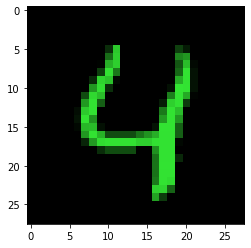

KeyboardInterrupt: ignored

In [5]:
predictions = model.predict(X_test)
good_list = tuple(zip(X_test, predictions[0], predictions[1]))
for (test, prediction, color) in good_list:
    clear_output(wait=True)
    print(np.argmax(prediction))
    col = np.argmax(color)
    if col == 0:
        print("red")
    if col == 1:
        print("blue")
    if col == 2:
        print("green")
    test = np.reshape(test,(28,28,3))
    plt.imshow(test)
    plt.show()
    time.sleep(1.5)

# Just for Randomizing image color
### if you want to try, run after getting the data from mnist

In [2]:
# colorize images

random.seed()

def apply_mask(img, mask):
    for i, col in enumerate(img[:]):
        for j, pixel in enumerate(col[:]):
            if pixel[0] != 0.0:
                img[i,j] = [pixel[0]*mask[0], pixel[1]*mask[1], pixel[2]*mask[2]]
    return img

! mkdir images
! mkdir images/train
! mkdir images/test

# returns randomized color images and its solution
def randomize_colors(data, data_sol, data_type):
    data = data / 255.
    data = np.expand_dims(data,3)
    randomized_data = np.zeros([len(data), 28, 28, 3])
    solution = np.zeros([len(data), len(colors)])
    for i, img in enumerate(data):
        img = np.concatenate((data[i], np.expand_dims(data[i][:,:,0], 2)), axis=2)
        randomized_data[i] = np.concatenate((img, np.expand_dims(data[i][:,:,0], 2)), axis=2)
        rand = random.randint(0,len(colors)-1)
        randomized_data[i] = apply_mask(randomized_data[i], colors[rand])
        solution[i,rand] = 1.
        name = "images/{}/image{:05d}".format(data_type,i)
        np.save(name,np.array((randomized_data[i], data_sol[i], solution[i]), dtype=object))
        keras.preprocessing.image.save_img(name+".png",randomized_data[i])
        if i % 1000 == 0:
            print("\r{:3.2f}% {} ".format((i/len(data))*100,getMemUse()), end='')
    print("\r100% {} ".format(getMemUse()))
    return (randomized_data, solution)

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)
X_train, Y_train_color = randomize_colors(X_train,Y_train,"train")
X_test, Y_test_color = randomize_colors(X_test,Y_test,"test")

11493376/11490434 [==============================] - 0s 0us/step
100%  mem use: 1.86705MB  
100%  mem use: 1.86705MB  
